# Preliminaries

In [33]:
# import modules
import numpy as np
#... # your code here
import sklearn
import pandas as pd
import seaborn as sn
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [19]:
# base classes

class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

# **2)** Density Tree and Decison Tree

## Density Tree

In [20]:
class DensityTree(Tree):
    def __init__(self):
        super(DensityTree, self).__init__()
        
    def train(self, data, prior, n_min=20):
        '''
        data: the feature matrix for the digit under consideration
        prior: the prior probability of this digit
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        self.prior = prior
        N, D = data.shape
        D_try = int(np.sqrt(D)) # number of features to consider for each split decision

        # find and remember the tree's bounding box, 
        # i.e. the lower and upper limits of the training feature set
        m, M = np.min(data, axis=0), np.max(data, axis=0)
        self.box = m.copy(), M.copy()
        
        # identify invalid features and adjust the bounding box
        # (If m[j] == M[j] for some j, the bounding box has zero volume, 
        #  causing divide-by-zero errors later on. We must exclude these
        #  features from splitting and adjust the bounding box limits 
        #  such that invalid features have no effect on the volume.)
        valid_features   = np.where(m != M)[0]
        invalid_features = np.where(m == M)[0]
        M[invalid_features] = m[invalid_features] + 1

        # initialize the root node
        self.root.data = data
        self.root.box = m.copy(), M.copy()

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_density_split_node()' with 'D_try' randomly selected 
                # indices from 'valid_features'. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                #... # your code here
                feature_indices = np.random.choice(valid_features, D_try, replace=False)
                left, right = make_density_split_node(node, N, feature_indices)
                stack.extend([left, right])

            else:
                # Call 'make_density_leaf_node()' to turn 'node' into a leaf node.
                #... # your code here
                make_density_leaf_node(node, N)

    def predict(self, x):
        leaf = self.find_leaf(x)
        # return p(x | y) * p(y) if x is within the tree's bounding box 
        # and return 0 otherwise
        #return ... # your code here
        return leaf.response * self.prior

In [21]:
def make_density_split_node(node, N, feature_indices):
    '''
    node: the node to be split
    N:    the total number of training instances for the current class
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    m, M = node.box

    valid_features   = np.where(m != M)[0]
    invalid_features = np.where(m == M)[0]
    M[invalid_features] = m[invalid_features] + 1

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = None, None
    
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 
        # 'np.unique()'. Describe here why this is necessary. Otherwise a threshold might
        # coincide with a feature value so that later we could not split the data correctly
        #data_unique = ...(node.data[:, j])
        data_unique = np.unique(node.data[:, j])
        # Compute candidate thresholds
        #tj = ...
        tj = (data_unique[1:] - data_unique[0:-1]) / 2 + data_unique[0:-1]

        # calculate Volume without the feature j
        dist_Mm = (M - m)
        V_temp = np.prod(dist_Mm) / (M[j] - m[j])
      
        
        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            # Compute the error
            #loo_error = ...
            N_l = len(np.where(node.data[:, j] < t)[0])
            V_l = V_temp * (t - data_unique[0])
            err_l = N_l / (N * V_l) * (N_l / N - 2 * (N_l - 1) / (N - 1))
            N_r = N - N_l
            V_r = V_temp * (data_unique[-1] - t)
            err_r =  N_r / (N * V_r) * (N_r / N - 2 * (N_r - 1) / (N - 1))
            # need to multiply (1 / V_temp) to get the full Volume of left
            # and right node
            loo_error = 1 / V_temp * (err_r + err_l)
            
            # choose the best threshold that
            if loo_error < e_min:
                e_min = loo_error
                j_min = j
                t_min = t

    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    
    # finding left and right indices of data
    
    indices_left = np.where(node.data[:, j_min] < t_min)[0]
    indices_right = np.where(node.data[:, j_min] >= t_min)[0]
  
    left.data = node.data[indices_left, :] # store data in left node -- for subsequent splits
    left.box = np.min(left.data, axis=0), np.max(left.data, axis=0) # store bounding box in left node
    right.data = node.data[indices_right, :]
    right.box = np.min(right.data, axis=0), np.max(right.data, axis=0)
    

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

In [22]:
def make_density_leaf_node(node, N):
    '''
    node: the node to become a leaf
    N:    the total number of training instances for the current class
    '''
    # compute and store leaf response
    n = node.data.shape[0]
    #v = ...
    #node.response = ...
    m, M = node.box
    valid_features   = np.where(m != M)[0]
    invalid_features = np.where(m == M)[0]
    M[invalid_features] = m[invalid_features] + 1
    v = np.prod(M - m)
    node.response = n / (N * v)

# Decision Tree

In [23]:
# new node definition because I did things differently
class Node:
  
    threshold = None
    data = None
    N = None
    response = None
    labels = None
    gini_impurity = None
    
    #left and right children
    left = None
    right = None
    
    def _init_(self):
        pass
class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

In [24]:
class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision
        randomizer = np.random.permutation(range(D))[0:D_try] #select random permutations
        
        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        self.root.gini_impurity = gini_impurity_calc(data, labels)
        
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                make_decision_split_node(node, randomizer)
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                make_decision_leaf_node(node)
                
    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        return leaf.response

In [43]:
def gini_impurity_calc(data, labels):
    """
    Calculates gini impurity as described in the exercise
    """
    num = np.unique(labels, return_counts = True)[1]
    return (1 - np.sum((num**2)/(len(data)**2)))

def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    labels = node.labels
    
    gini_best = float("inf")
    j_best, t_best = None, None
    # find best feature j (among 'feature_indices') and best threshold t for the split
    for j in feature_indices:
        unique_data = np.unique(node.data[:,j])
        thresholds_js = 0.5*(unique_data[1:-1] + unique_data[0:-2])
        
        for threshold in thresholds_js:
            #calculate number of instances in left or right boxes
            left_instance_num = labels[np.where(node.data[:,j] <= threshold)[0]]
            right_instance_num = labels[np.where(node.data[:,j] > threshold)[0]]
            
            #calculate gini impurities for left and right boxes
            left_gini = len(left_instance_num)*gini_impurity_calc(left_instance_num, left_instance_num)
            right_gini = len(right_instance_num)*gini_impurity_calc(right_instance_num, right_instance_num)
            
            gini_sum = left_gini + right_gini
            
            #check if the gini impurity is small enough
            if gini_sum < gini_best:
                j_best = j
                t_best = threshold
                gini_best = gini_sum
                
    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data = node.data[np.where(node.data[:,j_best] <= t_best)[0]].copy() # data in left node
    left.labels = labels[np.where(node.data[:,j_best] <= t_best)[0]].copy()# corresponding labels
    right.data = node.data[np.where(node.data[:,j_best] > t_best)[0]].copy() # same for right node
    right.labels = labels[np.where(node.data[:,j_best] > t_best)[0]].copy()

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_best
    node.threshold = t_best

    # return the children (to be placed on the stack)
    return left, right    

In [26]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    counts, node.N = np.unique(node.labels, return_counts=True)
    node.response = counts[np.argmax(node.N)]

In [27]:
def node_is_pure(node):
    '''
    check if 'node' contains only instances of the same digit
    '''
    if(np.unique(node.labels).shape[0] <=1):
        return True
    else: 
        return False

# **3)** Evaluation of Density and Decision Tree

In [28]:
# read and prepare the digits data
#... # your code here
digits = load_digits()
data = digits["data"]
target = digits["target"]

## Density Tree

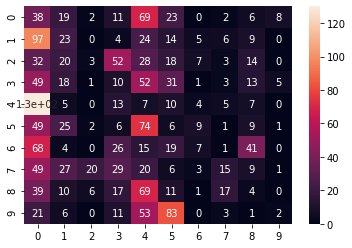

Error density tree: 0.9360044518642181


In [34]:
# train trees, plot training error confusion matrices, and comment on your results
#... # your code here

# training 10 trees for each number from 0 to 9
N_tot = data.shape[0]
trained_trees = []

for number in range(10):
    indices = np.where(target == number)[0]
    prior = np.sum(target == number) / N_tot
    X = data[indices, :]
    tree = DensityTree()
    tree.train(X, prior, n_min=20)
    trained_trees.append(tree)


# evaluating trained trained trees
predic_trees = np.zeros(N_tot)

for instance in range(N_tot):
    predic_temp = np.zeros(10)
    for number in range(10):
        pred = trained_trees[number].predict(data[instance, :])
        predic_temp[number] = pred
    predic_trees[instance] = np.argmax(predic_temp)

# plotting confusion matrix
confusion = confusion_matrix(target, predic_trees)

confusion_pd = pd.DataFrame(confusion, index = np.arange(0,10), columns = np.arange(0,10))

plt.figure()
sn.heatmap(confusion_pd, annot=True)
plt.show()

accuracy_dens = np.sum(predic_trees == target) / N_tot
error_dens = 1 - accuracy_dens

print('Error density tree:', error_dens)

As one can see the Density tree does not work well. The confusion matrix does not have a diagonal structure and the error is very high.

## Decision Tree

In [35]:
# train trees, plot training error confusion matrices, and comment on your results
#... # your code here
N_tot = data.shape[0]

decTree = DecisionTree()
decTree.train(data, target, n_min=20)

# evaluating trained trained tree
predic_tree = np.zeros(N_tot)

for instance in range(N_tot):
    pred = decTree.predict(data[instance, :])
    predic_tree[instance] = pred


# plotting confusion matrix
confusion = confusion_matrix(target, predic_tree)

confusion_pd = pd.DataFrame(confusion, index = np.arange(0,10), columns = np.arange(0,10))

plt.figure()
sn.heatmap(confusion_pd, annot=True)
plt.show()

accuracy_dec = np.sum(predic_tree == target) / N_tot
error_dec = 1 - accuracy_dec

print('Error decision tree:', error_dec)

ValueError: ignored

# **4)** Density Forest and Decison Forest

In [36]:

class DensityForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DensityTree() for i in range(n_trees)]

    def train(self, data, prior, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            #... # your code here
            # random indices for bootstrap training
            indices = np.random.choice(np.arange(0, data.shape[0]), data.shape[0])
            #print('indices', indices)
            data_train = data[indices, :]
            tree.train(data_train, prior, n_min=20)

    def predict(self, x):
        # compute the ensemble prediction
        #return ... # your code here
        predic_arr = [tree.predict(x) for tree in self.trees]
        average_predic = np.mean(np.array(predic_arr))

        return average_predic

In [37]:
class DecisionForest():
  def __init__(self, n_trees):
      # create ensemble
      self.trees = [DecisionTree() for i in range(n_trees)]

  def train(self, data, labels, n_min=0):
      for tree in self.trees:
          # train each tree, using a bootstrap sample of the data
          #... # your code here
          # random indices for bootstrap training
          indices = np.random.choice(np.arange(0, data.shape[0]), data.shape[0])
          data_train = data[indices, :]
          labels_train = labels[indices]
          tree.train(data_train, labels_train, n_min=n_min)


  def predict(self, x):
      # compute the ensemble prediction
      #return ... # your code here
      predic_arr = [tree.predict(x) for tree in self.trees]
      majority_label = np.argmax(np.bincount(predic_arr))

      return majority_label

# **5)** Evaluation of Density Forest and Decison Forest

## Density Forest

In [38]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
#... # your code here

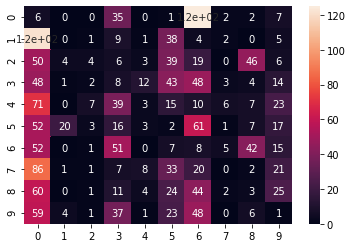

Error of density forests: 0.9805230940456316


In [39]:
# training 10 Forests (20 trees each) for each number from 0 to 9
N_tot = data.shape[0]
trained_forests = []

for number in range(10):
    indices = np.where(target == number)[0]
    prior = np.sum(target == number) / N_tot
    X = data[indices, :]
    Forest = DensityForest(n_trees=20)
    Forest.train(X, prior, n_min=20)
    trained_forests.append(Forest)

# evaluating trained trained  forests
predic_forests = np.zeros(N_tot)

for instance in range(N_tot):
    predic_temp = np.zeros(10)
    for number in range(10):
        pred = trained_forests[number].predict(data[instance, :])
        predic_temp[number] = pred
    predic_forests[instance] = np.argmax(predic_temp)


# plotting confusion matrix
confusion = sklearn.metrics.confusion_matrix(target, predic_forests)

confusion_pd = pd.DataFrame(confusion, index = np.arange(0,10), columns = np.arange(0,10))

plt.figure()
sn.heatmap(confusion_pd, annot=True)
plt.show()

accuracy_densforest = np.sum(predic_forests == target) / N_tot
error_densforest = 1 - accuracy_densforest

print('Error of density forests:', error_densforest)

As one would expect the density forest also does not perform well, as already a single density tree did not perform well. 

##Decison Forest

In [42]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
#... # your code here

# training one decison forest with 20 trees
N_tot = data.shape[0]

forest_dec = DecisionForest(n_trees=20)
forest_dec.train(data, target, n_min=0)

predic_forest_dec = np.zeros(N_tot)

for instance in range(N_tot):
    predic_forest_dec[instance] = forest_dec.predict(data[instance, :])

# plotting confusion matrix
confusion = sklearn.metrics.confusion_matrix(target, predic_forest_dec)
confusion_pd = pd.DataFrame(confusion, index = np.arange(0,10), columns = np.arange(0,10))

plt.figure()
sn.heatmap(confusion_pd, annot=True)
plt.show()

accuracy_forest_dec = np.sum(predic_forest_dec == target) / N_tot
error_forest_dec = 1 - accuracy_forest_dec

print('Error of decision forest:', error_forest_dec)

TypeError: ignored

In general one expects the decision trees and forests to perform better than the density trees and forests. This is because it is much harder to train generative models.

WE couldn't test the decision tree, since we were a bit late, so the evaluation probably doesn't work. 

## Results from sklearn

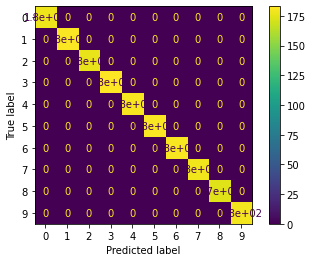

In [ ]:
# Using sklearn.ensemble.RandomForestClassifier() with default paramters
n_trees = 20
sklearn_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees)
sklearn_forest.fit(data, target)

# plotting confusion matrix with built in function
sklearn.metrics.plot_confusion_matrix(sklearn_forest, data, target)
plt.show()


The RandomForestClassifier() from sklearn shows the best performance as the confusion matrix has a perfect diagonal form.